## General info

Aids: python help file "python_help_230924.ipynb"

You can hand in hand-written answers (or part of answers). These will be collected after the exam. On the envelope of the hand-written papers write your computer name. 

Comment your code in your files (.ipynb or .py) to explain your solutions/answers. Save these codes/files under c:\__exam__\Assignments\

On the top of each file write your anonymous code e.g. #ims135-123456



## Grading

max point= 27p

grade 5: 22-27p (80-100%)

grade 4: 16-21p (60-80%)

grade 3: 11-15 (40-60%)


(the exact number of max points can differ between different exams)

In [1]:
#useful packages (from python help file)
import numpy as np
from numpy import linalg as LA
import math as mt
import os
from matplotlib.image import imread
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing default values
import scipy.io as sio
import scipy.optimize
from scipy.optimize import minimize
import timeit
import torch
from torch.autograd import grad
import torch.nn as nn
import torch.optim as optim
import random
from scipy.integrate import odeint

## 1. (3p)

Explain the fundamental differences between regression, classification, and clustering in machine learning. Provide examples of  applications for each of these tasks and tell whether they belong to supervised or unsupervised learning methods.

Answer (from Chat GPT):

Machine learning encompasses various tasks, and three fundamental types are regression, classification, and clustering. Each of these tasks serves distinct purposes in data analysis and pattern recognition.

1. Regression:

Definition: Regression is a supervised learning task that deals with predicting a continuous output or numerical value based on input data. It aims to model the relationship between the independent variables and the dependent variable.
Example: Predicting house prices based on features like square footage, number of bedrooms, and location.

2. Classification:

Definition: Classification is another supervised learning task where the goal is to categorize data points into predefined classes or categories. It's used when the output is discrete or categorical.
Example: Classifying emails as spam or not spam based on their content or categorizing images of animals into various species.

3. Clustering:

Definition: Clustering is an unsupervised learning task that focuses on grouping similar data points together based on their inherent similarities. It aims to discover patterns or structures within the data.
Example: Segmenting customers into distinct groups for targeted marketing based on their purchasing behavior.


In summary, regression is used for predicting numerical values, classification is employed for labeling data into predefined classes, and clustering identifies natural groupings within data. The choice of task depends on the nature of the problem and the type of output you want to obtain. Different evaluation metrics are used to assess the performance of models in each of these task categories, reflecting their specific objectives. Understanding these task types is essential for selecting the right approach in various machine learning applications.

## 2. (5p)

Assume that you have obtained experimental data in the form of snapshots of 20 displacements at 400 time instances. The data is stored in the matrix X, which you can find in the file bar_result.mat . The displacements are measured in millimeters (mm) and are recorded at 20 locations between $x=0$ m to $x=1$ m. The time instances are recorded between $t=0$ s to $t=0.4$ s.

a) Calculate the singular values of the matrix $X$ and give the 4 largest.

b) Use SVD to approximate the data matrix X by retaining only the top 3 singular values. Determine the L2 norm of the error between  the approximated $X$ and the original $X$, and also, calculate how many numerical values need to be stored for this approximation compared to for the full $X$.

c) Generate plots to visualize the spatial and temporal patterns for the three terms retained in the SVD approximation.



4 largest singular values=  [3.71921422 0.0601966  0.0395538  0.01205318]
L2 error of the approximated X= 0.012053178524688226
kalle 0.014820837252331345
relative number of stored values= 0.157875
number of stored values= 1263
originally= 8000


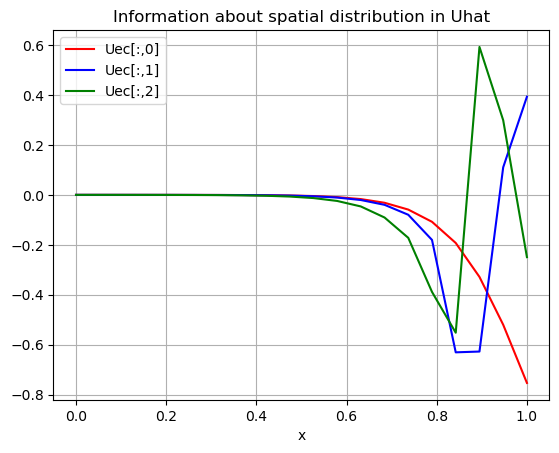

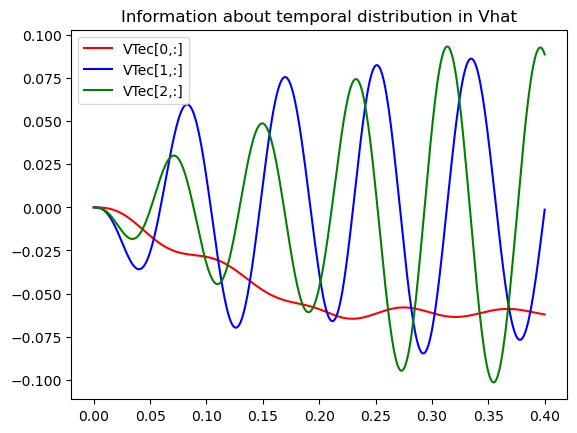

In [8]:
#Load data from .mat file, example
mat_file=sio.loadmat('DATA/bar_result.mat')
X=mat_file['X'] # Experimental data #x and time coordinates
x=np.linspace(0.,1.,np.size(X,0))
t=np.linspace(0.,0.4,np.size(X,1))

#economy SVD of X
Uec, Sec, VTec=np.linalg.svd(X,full_matrices=False)

print('4 largest singular values= ',Sec[0:4])

#approximation
r=3
Sec_matrix=np.diag(Sec)
Xapprox=Uec[:,0:r] @ Sec_matrix[0:r,0:r] @ VTec[0:r,:]
print('L2 error of the approximated X=',np.linalg.norm(X-Xapprox,2))
print('relative number of stored values=',(r+np.size(Uec,0)*r+np.size(VTec,1)*r)/(np.size(X, 0) * np.size(X, 1)))
print('number of stored values=',(r+np.size(Uec,0)*r+np.size(VTec,1)*r))
print('originally=',np.size(X, 0) * np.size(X, 1))

# Create a figure for spatial distribution visualization
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel('x', fontsize=10)
ax.set_title('Information about spatial distribution in Uhat')
ax.grid(visible=True)

# Plot the spatial distribution of the data and the first singular vector
ax.plot(x, Uec[:, 0] , label='Uec[:,0]', linestyle='-', color='red')
ax.plot(x, Uec[:, 1] , label='Uec[:,1]', linestyle='-', color='blue')
ax.plot(x, Uec[:, 2] , label='Uec[:,2]', linestyle='-', color='green')
ax.legend(loc='best')

# Create a figure for temporal distribution visualization
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(t, VTec[0, :] , label='VTec[0,:]', linestyle='-', color='red')
ax.plot(t, VTec[1, :] , label='VTec[1,:]', linestyle='-', color='blue')
ax.plot(t, VTec[2, :] , label='VTec[2,:]', linestyle='-', color='green')
ax.set_title('Information about temporal distribution in Vhat')
ax.legend(loc='best')

# Show the plots
plt.show()

## 3. (3p)
Find the values of $x_1$ and $x_2$ that minimize the function $f(x_1,x_2)=(x_2-1)^2-(x_2-1) \cdot ( (x_1+1)^2+(x_2-1)^2)+( (x_1+1)^2+(x_2-1)^2)^2$. For this optimization task, use the PyTorch implementations of the optimization algorithms stochastic gradient descent (torch.optim.SGD) and LBFGS. Use the initial guess $x_1=x_2=0$. Perform the optimization with two different learning rates: 0.1 and 1.  Discuss the results obtained for both algorithms with the varying learning rates and elaborate on the significance of the choice of learning rate in optimization problems.




In [3]:
###############
#Example using Pytorch LBFGS/sgd
import torch
import torch.optim as optim

# Define the cost function 
def dun87(x):
    return (x[1]-1.)**2.-(x[1]-1.)*( (x[0]+1.)**2.+(x[1]-1.)**2.)+( (x[0]+1.)**2.+(x[1]-1.)**2.)**2.

# Initialize the parameters

for mycase in range(4):
    initial_x = np.zeros(2)  # Initial guess for optimization
    x = torch.tensor(initial_x, requires_grad=True)  # Convert initial guess to a PyTorch tensor
    # Initialize the optimizer
    if mycase==0:
        optimizer = optim.LBFGS([x], lr=0.1)
        id='LBFGS lr 0.1, '
    elif mycase==1:
        optimizer = optim.LBFGS([x], lr=1.)
        id='LBFGS lr 1, '
    elif mycase==2:
        optimizer=torch.optim.SGD([x], lr=0.1)
        id='SGD lr 0.1, '
    elif mycase==3:
        optimizer=torch.optim.SGD([x], lr=1.)
        id='SGD lr 1, '
        # Closure function used for optimization
    def closure():
        optimizer.zero_grad()  # Clear gradients from previous iteration
        loss = dun87(x) #rosenbrock(x)  # Compute the loss (Rosenbrock function in this case)
        loss.backward()  # Compute gradients using backpropagation
        return loss

    # Convergence criterion
    threshold = 1e-5

    # Perform optimization using the LBFGS optimizer
    prev_x = x.clone().detach()  # Clone the initial parameters for comparison
    iteration = 0  # Initialize iteration counter

    num_iterations = 1000  # Number of optimization iterations

    # Optimization loop
    while True:
        optimizer.step(closure)  # Perform optimization step by calling the closure function
    
        # Update previous parameter values
        prev_x = x.clone().detach()
    
        iteration += 1
    
        if iteration >= num_iterations:
            break

    # Print the final optimized values
    print(id,"Optimized values:")
    print("x =", x)

LBFGS lr 0.1,  Optimized values:
x = tensor([-0.9932,  1.0000], dtype=torch.float64, requires_grad=True)
LBFGS lr 1,  Optimized values:
x = tensor([-0.9946,  1.0000], dtype=torch.float64, requires_grad=True)
SGD lr 0.1,  Optimized values:
x = tensor([-1.0000,  1.0000], dtype=torch.float64, requires_grad=True)
SGD lr 1,  Optimized values:
x = tensor([nan, nan], dtype=torch.float64, requires_grad=True)


Answer from chat-GPT:

The choice of learning rate in optimization algorithms is a critical hyperparameter that can significantly impact the success of the optimization process. The learning rate determines the step size by which model parameters are updated during each iteration of the optimization algorithm. It plays a fundamental role in achieving convergence, stability, and efficiency in the optimization process. Here are some key points to discuss its significance:

Convergence Speed: The learning rate directly influences the convergence speed of the optimization algorithm. A larger learning rate results in faster convergence, as it allows for larger steps toward the optimal solution. However, an excessively large learning rate can lead to overshooting the minimum and oscillations in the objective function, causing instability.

Stability and Divergence: If the learning rate is too large, the optimization process may diverge, making it impossible to reach a minimum. Conversely, a learning rate that is too small can lead to slow convergence or getting stuck in local minima. The choice of an appropriate learning rate is essential for achieving stability and ensuring that the optimization process converges to a solution.

Effect on Accuracy: The learning rate can also impact the accuracy of the final solution. A well-tuned learning rate balances the trade-off between speed and accuracy. An optimal learning rate allows the algorithm to efficiently navigate the loss surface and converge to a solution that is both fast and accurate.

Hyperparameter Tuning: In practice, choosing the right learning rate often requires hyperparameter tuning. Researchers and practitioners often experiment with various learning rates and employ techniques like learning rate schedules, adaptive learning rates, or advanced optimization algorithms to find an optimal learning rate for their specific problem.

Generalization: The choice of learning rate can affect the generalization performance of machine learning models. Overly large learning rates may result in models that fit the training data too closely (overfitting), while extremely small learning rates can lead to underfitting, where the model fails to capture important patterns in the data.

In conclusion, the choice of learning rate is a critical consideration in optimization. It influences the convergence speed, stability, accuracy, and generalization of the optimization process. An optimal learning rate strikes a balance between fast convergence and accurate results, and finding the right learning rate often requires experimentation and hyperparameter tuning tailored to the specific problem at hand.






## 4. (3p)
Cross-validation is a critical step in machine learning model development. Explain how such a procedure can be conducted and disuss why it is essential to perform a cross-validation procedure.

Answer:

Cross-validation is a critical step in machine learning model development. It involves:

1) Data Splitting: Dividing the dataset into training and withhold (test) data

2) Training and Testing: Repeatedly training the model on a portion of the training data and testing it the remaining training data. Based on these results choose one set of parameter values.

3) Performance Assessment: Calculating the error against the withhold data.

Cross-validation is essential because it provides a robust assessment of a model's performance and in particular helps to avoid overfitting.

## 5. (3p)
For the NN in the figure:
![simple nn from Fig 3.5 in Kollmannsberger et al](fig/simple_nn.png "MarineGEO logo")  
Assume $w_{11}^{(1)}=1$, $w_{12}^{(1)}=-3$, $w_{21}^{(1)}=-2$, $w_{22}^{(1)}=1$, $w_{1}^{(2)}=2$, $w_{2}^{(2)}=-1$ and that the activation functions are the tanh. Determine the gradients of the weights (=parameters of the NN) on the the output $\hat{y}$ for $x=[3,2]$. 

In [21]:
x=np.array([3.,2.])

w1=np.array([[1,-3.],[-2.,1]])

w2=np.array([2.,-1])

print('np output',np.tanh( np.dot(w2,np.tanh(w1@x))))

xt=torch.tensor(x, requires_grad=False)
w1t=torch.tensor(w1, requires_grad=True)
z1t=w1t@xt
a1t=torch.tanh(z1t)

w2t=torch.tensor(w2, requires_grad=True)
z2t=w2t@a1t

a2t=torch.tanh(z2t)
yhatt=a2t
print(yhatt)
#compute gradient
yhatt.backward()
# Access the gradients
dyhat_dw1 = w1t.grad
print("Gradient dyhat_dw1:", dyhat_dw1)
dyhat_dw2 = w2t.grad
print("Gradient dyhat_dw2:", dyhat_dw2)

np output -0.7576948100207186
tensor(-0.7577, dtype=torch.float64, grad_fn=<TanhBackward0>)
Gradient dyhat_dw1: tensor([[ 0.0252,  0.0168],
        [-0.0017, -0.0011]], dtype=torch.float64)
Gradient dyhat_dw2: tensor([-0.4238, -0.4256], dtype=torch.float64)


## 6. (5p)

Measurements of beam deflections have been conducted (for the same material and loading). Five different beams with with the following lengths and quadratic cross-section widths have been tested. 

$L=1, \, 1, \, 3, \, 5, \, 7 $

$b=1, \, 2, \, 1, \, 2, \, 3 $

The measurements gave the deflections: 

$4.1, \, 0.25, \, 107, \, 31, \, 17$

a) Try to fit a NN to the experimental data. Assume 2 hidden layers with 10 neurons in both these layers. Apply the sigmoid activation function. Compute the output for the trained NN for the measurements.

b) An additional experiment has been conducted. The displacement was measured to $31.2$ for the length $5$ and quadratic cross-section width $2$. Compute the results from your trained NN.


Note, that the all measurement results, lengths and widths have been made dimensionless. Furthermore, you can use any regularization parameter and optimization algorithm (with tolerances etc.) that works for you.  


In [18]:
input_data=torch.tensor([[1.,1.],[1.,2.],[3.,1.],[5.,2.],[7.,3.]],dtype=torch.float32) #input torch.tensor to your NN for the experiments
target_data=torch.tensor([[4.1],[0.25],[107.],[31],[17]],dtype=torch.float32)     


def my_nn(input_data,target_data,lambda_l1,optim_alg):
    ## Convert the data to PyTorch tensors
    #x_tensor = torch.from_numpy(x).float().unsqueeze(1)
    #y_tensor = torch.from_numpy(y).float().unsqueeze(1)

    # Define the neural network model
    class MyNet(nn.Module):
        def __init__(self):
            super(MyNet, self).__init__()
            self.fc1 = nn.Linear(2, 10)   
            self.fc2 = nn.Linear(10, 10)
            #self.fc3 = nn.Linear(10, 10)
            self.fc = nn.Linear(10, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.sigmoid(self.fc1(x))
            x = self.sigmoid(self.fc2(x))
            #x = self.sigmoid(self.fc3(x))
            x = self.fc(x)
            return x

    # Set a random seed for reproducibility, the same initial guess
    torch.manual_seed(0)
    
    # Create an instance of the SinNet model
    model = MyNet()  

    # Define the loss function
    criterion = nn.MSELoss()

    # Create a function for LBFGS closure

    def closure():
        optimizer.zero_grad()
        outputs = model(input_data)
        loss = criterion(outputs, target_data)
    # Calculate the L1 regularization term
        l1_regularization = torch.tensor(0.)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)
    
        # Add the L1 regularization term to the loss
        loss += lambda_l1 * l1_regularization
        loss.backward()
        return loss

    
    prev_loss = float('inf')  # Initialize with a large value
    tolerance = 1.e-8
    max_no_epoch=10000

    if optim_alg=='LBFGS':
        optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=1000,tolerance_change=tolerance)
    #alternatively:
    elif optim_alg=='Adam': 
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    elif optim=='SGD': 
        optimizer=torch.optim.SGD(model.parameters(), lr=0.1)

    


    # Training loop
    for epoch in range(max_no_epoch):
        def closure_wrapper():
            loss = closure()
            return loss
        optimizer.step(closure_wrapper)

    # Print the loss every 10th epoch
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}], Loss: {closure().item():.4f}")

        loss = closure()
    
        loss_change = prev_loss - loss.item()
        prev_loss = loss.item()
    
        # Check if the optimizer has converged (you can modify this condition)
    
        if optim_alg=='LBFGS':
            if loss_change < tolerance:
                print(f"Optimizer has converged. Stopping training.")
                break

    # Plot the original data and the fitted curve
    #plt.scatter(x, y, label='Original Data')
    #plt.plot(x, model(x_tensor).detach().numpy(), 'r', label='Fitted Curve')
    #plt.xlabel('x')
    #plt.ylabel('y')
    #plt.legend()
    #plt.show()
    
    return model

optim_alg='LBFGS' #'LBFGS' #'Adam'  #'LBFGS'
# Define the L1 regularization strength (lambda)
lambda_l1 = 0.001  # You can adjust this value
mymodel=my_nn(input_data,target_data,lambda_l1,optim_alg)


Optimizer has converged. Stopping training.


In [19]:
print('a) My predictions: ',mymodel(input_data))
print('target data: ',target_data)
print('b) My prediction: ',mymodel(torch.tensor([[5.,2.]])),' vs measured 31.2 ')

a) My predictions:  tensor([[  4.0370],
        [  0.3948],
        [106.9873],
        [ 30.9987],
        [ 17.0092]], grad_fn=<AddmmBackward0>)
target data:  tensor([[  4.1000],
        [  0.2500],
        [107.0000],
        [ 31.0000],
        [ 17.0000]])
b) My prediction:  tensor([[30.9987]], grad_fn=<AddmmBackward0>)  vs measured 31.2 


## 7. (5p)

The conservation of mass for an axisymmetric plane flow problem can be written as

$$
\frac{d u}{d r}+C \, \frac{u}{r}=0
$$
where $C=1$. Now this equation is extended by allowing $C$ to vary with $r$. Determine $C(r)$ and $u(r)$ by using PINN. Compare the obtained $u(r)$ with the measurement points (see below). Apply a NN with one hidden layer, 20 neurons and the activation function $tanh$.

The measurement points of $u$ at different $r$ values can be (for simplicity) obtained from the following code snippet: 


In [16]:
N = 20
L = 1
a=2.

def generate_grid_1d(length, samples=20, initial_coordinate=L):
    """Generate an evenly space grid of a given length and a given number of samples."""

    # Generate the grid
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)

    # Reshape on a column tensor and return
    return x.view(samples, 1)

#grid points
r = generate_grid_1d(a, N)

#'measurements'
ua=3.
u_random=ua*a/r*torch.exp(0.1*(a-r))


Epoch [1], Loss: 1375.0333
Epoch [2], Loss: 1278.3120
Epoch [3], Loss: 1186.7040
Epoch [4], Loss: 1100.1775
Epoch [5], Loss: 1018.6322
Epoch [6], Loss: 941.9531
Epoch [7], Loss: 870.0433
Epoch [8], Loss: 802.8094
Epoch [9], Loss: 740.1764
Epoch [10], Loss: 682.1132
Epoch [11], Loss: 628.6586
Epoch [12], Loss: 579.9139
Epoch [13], Loss: 535.9276
Epoch [14], Loss: 496.4787
Epoch [15], Loss: 461.0736
Epoch [16], Loss: 429.2961
Epoch [17], Loss: 400.9870
Epoch [18], Loss: 376.1592
Epoch [19], Loss: 354.9018
Epoch [20], Loss: 337.3001
Epoch [21], Loss: 323.2928
Epoch [22], Loss: 312.4439
Epoch [23], Loss: 303.9038
Epoch [24], Loss: 296.8633
Epoch [25], Loss: 290.9343
Epoch [26], Loss: 286.0524
Epoch [27], Loss: 282.1770
Epoch [28], Loss: 278.9812
Epoch [29], Loss: 275.7970
Epoch [30], Loss: 272.0428
Epoch [31], Loss: 267.5936
Epoch [32], Loss: 262.6647
Epoch [33], Loss: 257.4874
Epoch [34], Loss: 252.0593
Epoch [35], Loss: 246.1843
Epoch [36], Loss: 239.7906
Epoch [37], Loss: 233.0993
Epoch

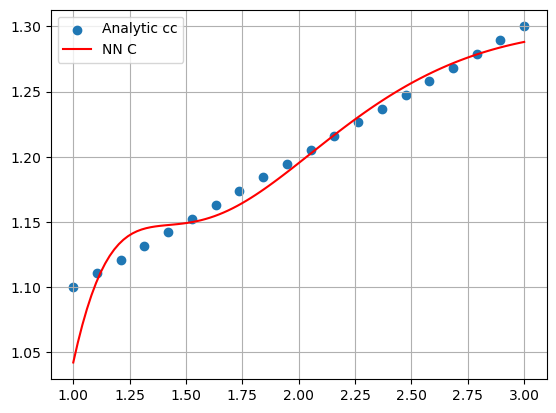

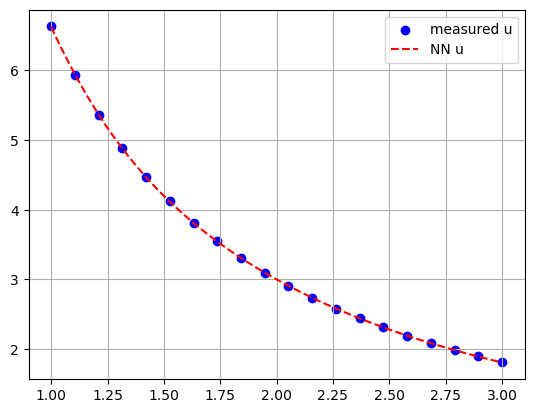

In [17]:
#solution
dtype = torch.float
device = torch.device("cpu")
from torch.autograd import grad

def get_derivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)
    


class pinnModel(nn.Module):
    def __init__(self):
        super(pinnModel, self).__init__()
        # Define layers for the neural network
        self.fc1 = nn.Linear(1, 20)  # Fully connected layer with 1 input and 10 output units
        self.fc2 = nn.Linear(20, 2)  # Fully connected layer with 10 input and 2 output units
        self.tanh = nn.Tanh()         # Tanh activation function

    def forward(self, x):
        # Define the forward pass of the neural network
        x = self.tanh(self.fc1(x))  # Apply sigmoid activation to the first layer
        x = self.fc2(x)  # Output layer (no activation function)
        return x
    
# Create an instance of the pinnModel model
model = pinnModel()

def closure(r):
    optimizer.zero_grad() # Clear gradients from the previous iteration
    output_tensor =model(r)
    u, C=torch.split(output_tensor,1,dim=1)
    du_dr=get_derivative(u, r, 1)
    # Differential equation loss
    loss_de = du_dr+C*u/r
    loss_de = torch.sum(loss_de ** 2).view(1)
    #measurement points loss
    MSEcriterion = nn.MSELoss()
    mse_loss = MSEcriterion(u, u_random)
    
# Calculate the L1 regularization term
    l1_regularization = torch.tensor(0.)
    for param in model.parameters():
        l1_regularization += torch.norm(param, p=1)

    # Add the L1 regularization term to the loss
    lambda_l1=0.
    loss = loss_de+100.*mse_loss+ lambda_l1 * l1_regularization # Compute the loss
    loss.backward(retain_graph=True) # Compute gradients using backpropagation
    # Manually release the computation graph
    #del loss, loss_de, mse_loss, l1_regularization
    return loss,loss_de


#%% training
prev_loss = float('inf')  # Initialize with a large value
tolerance = 1.e-7
max_no_epoch=8000



optim_alg='Adam'
if optim_alg=='LBFGS':
    optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=max_no_epoch,tolerance_change=tolerance)
#alternatively:
elif optim_alg=='Adam': 
    optimizer = optim.Adam(model.parameters(), lr=0.01)
elif optim=='SGD': 
    optimizer=torch.optim.SGD(model.parameters(), lr=0.1)


#for saving training result
differential_equation_loss_history = np.zeros(max_no_epoch)
# Training loop
for epoch in range(max_no_epoch):
    def closure_wrapper():
        loss,loss_de = closure(r)
        differential_equation_loss_history[epoch] = loss_de.item()
        return loss 
    loss=optimizer.step(closure_wrapper)
    
# Print the loss every epoch
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}], Loss: {loss.item():.4f}")
            
    loss_change = prev_loss - loss.item()
    prev_loss = loss.item()

    # Check if the optimizer has converged (you can modify this condition)

    if optim_alg=='LBFGS':
        if loss_change < tolerance:
            print(f"Optimizer has converged. Stopping training.")
            break


output_tensor =model(r)
u, C=torch.split(output_tensor,1,dim=1)

#%%
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(r.detach().numpy(), (1.+0.1*r).detach().numpy(), label='Analytic cc')
rdense = generate_grid_1d(a, 100)
output_tensor =model(rdense)
u, C=torch.split(output_tensor,1,dim=1)
plt.plot(rdense.detach().numpy(),C.detach().numpy(), 'r', label='NN C')
ax.grid(visible=True)
ax.legend(loc='best')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(r.detach().numpy(),u_random.detach().numpy(),color='blue',label='measured u')
plt.plot(rdense.detach().numpy(),u.detach().numpy(),color='red',linestyle='--',label='NN u')
ax.grid(visible=True)
ax.legend(loc='best') 
plt.show()


